# 📊 Exploratory Data Analysis – Daily Expenses Dataset

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

if not os.path.exists("eda"):
    os.makedirs("eda")
    
%matplotlib inline
sns.set(style="whitegrid")

# Set display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 10)


## 1. Load and Preprocess Data

In [13]:

df = pd.read_excel("data/data_assignment.xlsx", parse_dates=["Date"])
df['Income/Expense'] = df['Income/Expense'].str.strip().str.lower()
df['is_income'] = df['Income/Expense'].isin(['income', 'in', 'credit', '+'])
df['is_expense'] = df['Income/Expense'].isin(['expense', 'out', 'debit', '-'])
if not df['is_income'].any() and not df['is_expense'].any():
    df['is_income'] = df['Amount'] > 0
    df['is_expense'] = df['Amount'] < 0
df['signed_amount'] = np.where(df['is_income'], df['Amount'], -np.abs(df['Amount']))
df = df.sort_values('Date').reset_index(drop=True)
df.head()


,Date,Category,Income/Expense,Amount,is_income,is_expense,signed_amount
0,2025-03-01 13:30:00,Other,income,80.0,True,False,80.0
1,2025-03-01 15:50:00,Food,expense,35.0,False,True,-35.0
2,2025-03-01 17:07:00,Transportation,expense,5.2,False,True,-5.2
3,2025-03-02 14:16:00,Food,expense,3.9,False,True,-3.9
4,2025-03-02 14:16:00,Food,expense,3.6,False,True,-3.6


## 2. Summary Statistics

In [14]:

summary = df.groupby('Income/Expense')['Amount'].agg(['count', 'sum', 'mean', 'std', 'min', 'max']).T
summary


Income/Expense,expense,income
count,231.000000,49.000000
sum,2316.700000,2568.100000
mean,10.029004,52.410204
std,21.064734,86.854841
min,0.300000,0.100000
max,192.000000,400.000000


## 3. Breakdown by Category

In [15]:

cat_summary = df.groupby('Category')['Amount'].agg(['count', 'sum', 'mean', 'std']).sort_values('sum', ascending=False)
cat_summary['Type'] = df.groupby('Category')['Income/Expense'].first()
cat_summary


,count,sum,mean,std,Type
Category,,,,,
Other,60,1514.7,25.245000,58.020611,income
Food,156,935.9,5.999359,7.530022,expense
Allowance,6,560.0,93.333333,112.190314,income
Household,6,487.5,81.250000,87.414730,expense
Student Grant,3,378.0,126.000000,0.000000,income
Transportation,31,368.1,11.874194,17.061027,expense
Salary,1,320.0,320.000000,NaN,income
Apparel,7,135.6,19.371429,24.249654,expense
Social Life,5,100.5,20.100000,27.065661,expense


## 4. Daily Net Flow and Running Balance

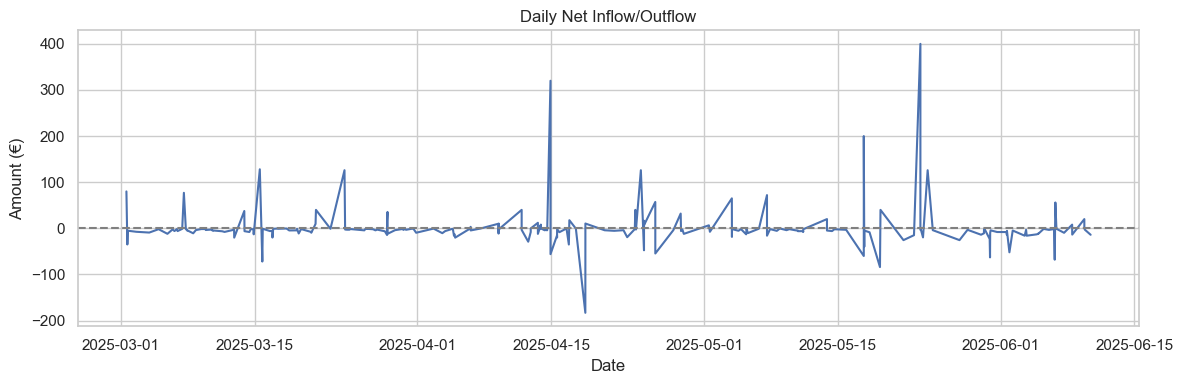

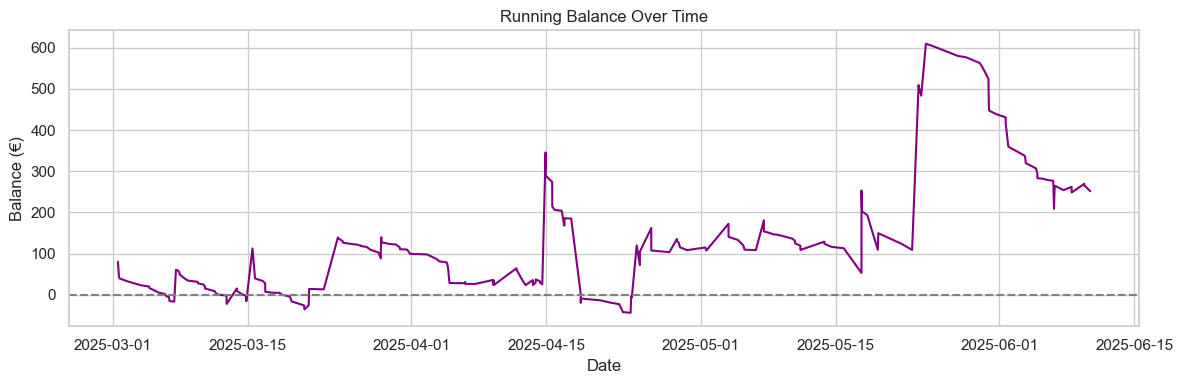

In [16]:

daily = df.groupby('Date')['signed_amount'].sum().reset_index()
daily['balance'] = daily['signed_amount'].cumsum()

plt.figure(figsize=(12, 4))
plt.plot(daily['Date'], daily['signed_amount'], label='Net Flow')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Daily Net Inflow/Outflow")
plt.xlabel("Date")
plt.ylabel("Amount (€)")
plt.tight_layout()
plt.savefig("eda/Daily Net Flow.png", dpi=300)
plt.show()



plt.figure(figsize=(12, 4))
plt.plot(daily['Date'], daily['balance'], label='Running Balance', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Running Balance Over Time")
plt.xlabel("Date")
plt.ylabel("Balance (€)")
plt.tight_layout()
plt.savefig("eda/Running Balance.png", dpi=300)
plt.show()




## 5. Distribution of Transaction Amounts

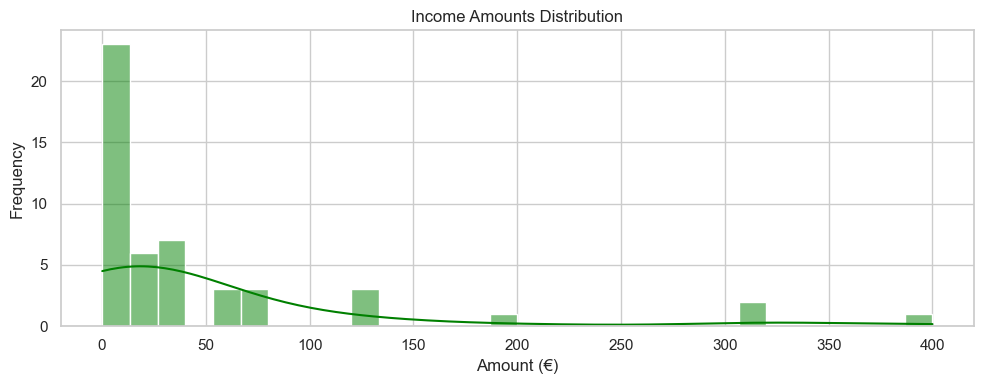

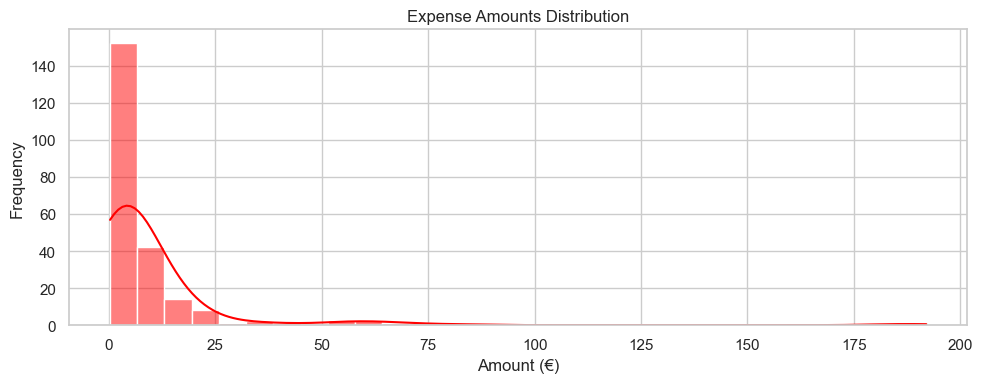

In [17]:

plt.figure(figsize=(10, 4))
sns.histplot(df[df['is_income']]['Amount'], bins=30, kde=True, color='green')
plt.title("Income Amounts Distribution")
plt.xlabel("Amount (€)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("eda/Income Amounts Distribution.png", dpi=300)
plt.show()



plt.figure(figsize=(10, 4))
sns.histplot(df[df['is_expense']]['Amount'].abs(), bins=30, kde=True, color='red')
plt.title("Expense Amounts Distribution")
plt.xlabel("Amount (€)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("eda/Expense Amounts Distribution.png", dpi=300)
plt.show()



## 6. Interarrival Time Analysis

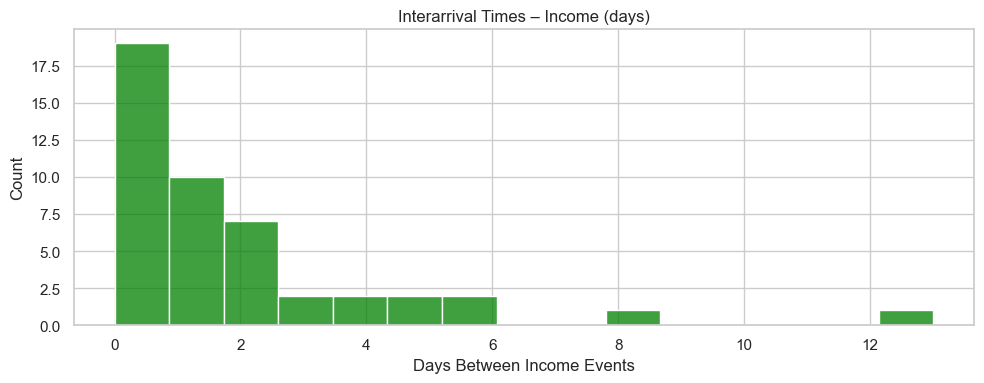

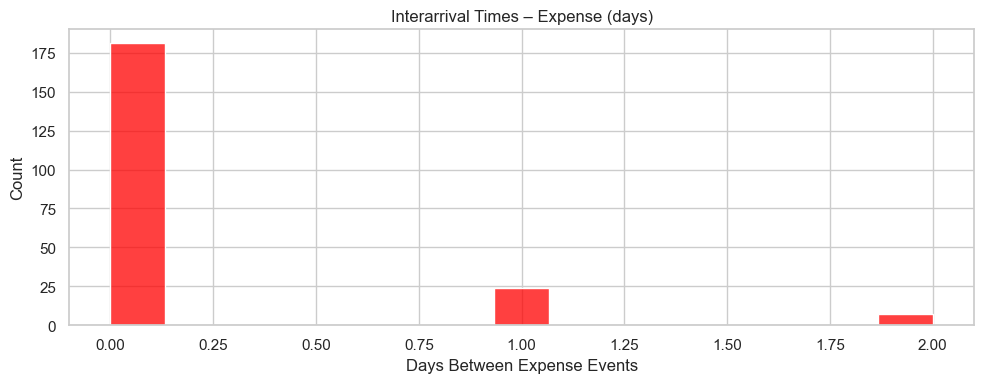

In [18]:

def interarrival(dates):
    sorted_dates = np.sort(pd.to_datetime(dates).unique())
    return np.diff(sorted_dates).astype('timedelta64[D]').astype(int)

inc_ia = interarrival(df.loc[df['is_income'], 'Date'])
exp_ia = interarrival(df.loc[df['is_expense'], 'Date'])

plt.figure(figsize=(10, 4))
sns.histplot(inc_ia, bins=15, kde=False, color='green')
plt.title("Interarrival Times – Income (days)")
plt.xlabel("Days Between Income Events")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("eda/Time and Income.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(exp_ia, bins=15, kde=False, color='red')
plt.title("Interarrival Times – Expense (days)")
plt.xlabel("Days Between Expense Events")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("eda/Time and Expense.png", dpi=300)
plt.show()


## 7. Day-of-Week Patterns

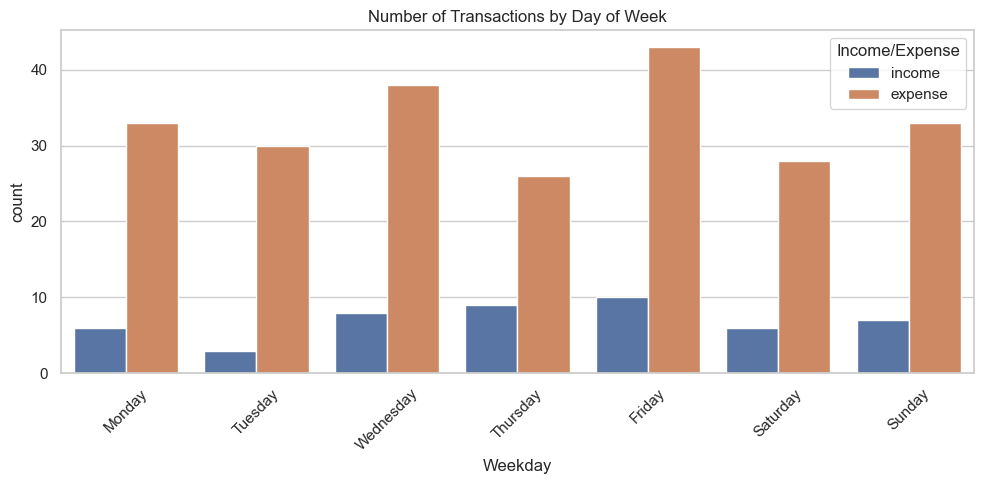

In [19]:

df['Weekday'] = df['Date'].dt.day_name()
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Weekday', hue='Income/Expense', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Number of Transactions by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("eda/Transaction by Day of Week.png", dpi=300)
plt.show()


## 8. Export Summary Tables

In [20]:

cat_summary.to_csv("eda/category_summary.csv")
daily.to_csv("eda/daily_balance.csv")
print("Saved 'category_summary.csv' and 'daily_balance.csv'")


Saved 'category_summary.csv' and 'daily_balance.csv'
